# Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
Необходимо получить R2 > 0.6 на Private Leaderboard.
Укажите свой ник на kaggle
Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии
Повторяющиеся операции лучше оформлять в виде функций
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна.
Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

# Connecting libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV, SGDRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV, Ridge
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import lightgbm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
%matplotlib inline
plt.rcParams['figure.figsize']=12,10
from sklearn.svm import LinearSVR

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
#Уменьшение объема памяти, который занимает датасет**

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2   #смотрим текущее потребление памчти нашим датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:   # проходимся по всем нашим столбцам
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Paths to directories and files

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

### Dataset description


* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

# Загрузка датасета

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [8]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


### Приведение типов

# EDA

### Detection and treatment of outliers

In [9]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None
        
    def fit(self, X):
        
        
        
        self.medians = X.median() # medians
        self.kitchen_square_max_value = np.quantile(X['KitchenSquare'], q=0.975) 
        self.kitchen_square_min_value = np.quantile(X['KitchenSquare'], q=0.001) 
        self.life_square_min_value = np.quantile(X['LifeSquare'], q=0.03)
        self.districts_healthcare = X.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
       
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        # Fillna with medians         
        X['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Compute median room square and fill outliers with LifeSquare/Room_square 
        condition_rooms = (X['Rooms'] > 6) | (X['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        X.loc[condition_rooms , 'Rooms'] = X.loc[condition_rooms, 'LifeSquare'] / room_sq
        

          # KitchenSquare
        # Fill outliers with (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (X['KitchenSquare'] > self.kitchen_square_max_value) | (X['KitchenSquare'] < self.kitchen_square_min_value)
        X.loc[condition_kitchen_square, 'KitchenSquare'] = X.loc[condition_kitchen_square, 'Square'] - X.loc[condition_kitchen_square, 'LifeSquare'] \
        - (X.loc[condition_kitchen_square, 'Square'] * 0.1)
                # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
                # LifeSquare
        # Fill outliers with (Square - KithcenSquare)
        ls_condition = (X['LifeSquare'] < self.life_square_min_value)
        X.loc[ls_condition, 'LifeSquare'] = X.loc[ls_condition, ['Square']] - X.loc[ls_condition, ['KitchenSquare']]
  
                # Square
        # If LifeSquare > Square: exchange values
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'],(X['LifeSquare'],X['Square']), (X['Square'],X['LifeSquare']))
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare
        # Fillna with dictrict healthcare value. (If district has no healthcare value fill with medians)      
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['DistrictId'].map(self.districts_healthcare)
        X['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(X['Healthcare_1'], q=0.9)
        X['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        # Drop Id
        X.drop(['Id'], axis=1, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [10]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [11]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
            
         # How old is the district      
        X['DistrictYear'] = X['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = X['DistrictYear'].median()
        X['DistrictYear'].fillna(self.median_district_year, inplace=True)
        
         # Median square of flat in each district
        X['DistrictDensity'] = X['DistrictId'].map(self.districts_density)
        self.median_district_density = X['DistrictDensity'].median()
        X['DistrictDensity'].fillna(self.median_district_density, inplace=True)
        
         # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        X['DistrictPrice'] = X['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = X['DistrictPrice'].median()
        X['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(X[['Social_1', 'Social_2', 'Social_3']]))
        X['Social'] = pca.fit_transform(social_scaled)
        X.drop(['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2'], axis=1, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    

    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
          
        return df
            
    

In [12]:
target_name = 'Price'

In [13]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [15]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 21), (3000, 21), (5000, 21))

In [16]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7000, 28), (3000, 28), (5000, 28))

In [17]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [18]:
X_train.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,DistrictYear,DistrictDensity,DistrictPrice,Social
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,...,7000.0,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,7000.00000,7000.000000,7000.000000,7.000000e+03
mean,50.219429,1.885569,56.294778,39.736103,6.620613,7.268143,12.827143,1984.675857,0.117966,24.638429,...,0.0,0.402571,1.643000,2.800429,210336.078808,196234.759427,1978.18800,53.298715,3803.055177,3.311637e-17
std,43.589014,0.811224,21.826683,22.119751,4.536482,4.975058,6.433842,18.368050,0.119445,17.555683,...,0.0,0.490451,1.277077,1.163956,76077.360400,27627.310029,9.51824,6.440712,1000.245016,4.707752e+00
min,0.000000,0.054572,2.377248,0.370619,3.000000,1.000000,1.000000,1912.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,82342.775873,159077.198056,1914.00000,33.533077,1727.928366,-1.594319e+00
25%,19.000000,1.000000,41.801913,24.976250,3.000000,3.000000,9.000000,1974.000000,0.017647,6.000000,...,0.0,0.000000,0.000000,2.000000,162138.526832,179661.919186,1974.00000,47.927342,2913.310685,-1.579974e+00
50%,34.500000,2.000000,52.509275,35.390303,6.000000,6.000000,12.000000,1977.000000,0.072158,25.000000,...,0.0,0.000000,2.000000,2.000000,193262.229890,188668.647925,1977.00000,54.756183,3947.319921,-1.183586e+00
75%,75.000000,2.000000,65.826944,48.637362,9.000000,10.000000,17.000000,2000.000000,0.194489,36.000000,...,0.0,1.000000,3.000000,3.000000,242280.301949,212604.477926,1980.00000,56.982855,4382.501726,-5.908179e-01
max,209.000000,5.320342,641.065193,638.163193,82.485682,42.000000,117.000000,2021.000000,0.521867,74.000000,...,0.0,1.000000,4.000000,5.000000,595128.195352,509182.957515,2013.00000,89.845913,8593.064137,2.661869e+01


In [19]:
X_valid.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,new_district,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,DistrictYear,DistrictDensity,DistrictPrice,Social
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03
mean,50.824000,1.902447,59.390465,40.043645,6.810387,7.600667,13.177333,1985.331667,0.120937,24.800333,...,0.000667,0.396667,1.723667,2.840000,208679.608518,197464.434047,1978.253833,53.379957,3795.724027,-5.573320e-17
std,43.588603,0.851775,137.144472,19.808843,5.002093,5.147689,6.466464,18.524778,0.118034,17.481066,...,0.025816,0.489287,1.285246,1.179914,72387.318706,28270.067001,9.572854,6.324700,987.312503,4.901688e+00
min,0.000000,1.000000,4.633498,0.795539,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,89683.296782,159077.198056,1914.000000,36.052307,1727.928366,-1.682017e+00
25%,21.000000,1.000000,41.925947,25.859309,3.000000,4.000000,9.000000,1974.000000,0.025609,6.000000,...,0.000000,0.000000,1.000000,2.000000,162821.511982,179661.919186,1974.000000,47.982081,2913.310685,-1.668774e+00
50%,37.000000,2.000000,52.920257,35.703023,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,...,0.000000,0.000000,2.000000,2.000000,193508.033366,188668.647925,1977.000000,54.756183,3966.567508,-1.272106e+00
75%,75.000000,2.000000,66.598344,48.661045,9.000000,11.000000,17.000000,2002.000000,0.200147,35.000000,...,0.000000,1.000000,3.000000,4.000000,241747.946284,214352.804457,1980.000000,56.895039,4382.501726,-6.709157e-01
max,208.000000,13.201945,7480.592129,211.231125,64.395756,37.000000,99.000000,2020.000000,0.521867,74.000000,...,1.000000,1.000000,4.000000,5.000000,593452.196978,393096.514494,2013.000000,89.845913,8593.064137,2.653017e+01


### Обработка данных

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

In [22]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
y_test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

In [23]:
scaler1 = MinMaxScaler()

In [24]:
X_train_scaled_min_max = pd.DataFrame(scaler1.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled_min_max = pd.DataFrame(scaler1.transform(X_valid), columns=X_valid.columns)
y_test_scaled_min_max = pd.DataFrame(scaler1.transform(test_df), columns=test_df.columns)

In [25]:
from sklearn.manifold import TSNE

In [26]:
tsne = TSNE(n_components=3, learning_rate=250, random_state=42)

In [27]:
%%time
X_train_tsne = tsne.fit_transform(X_train_scaled)

Wall time: 1min 42s


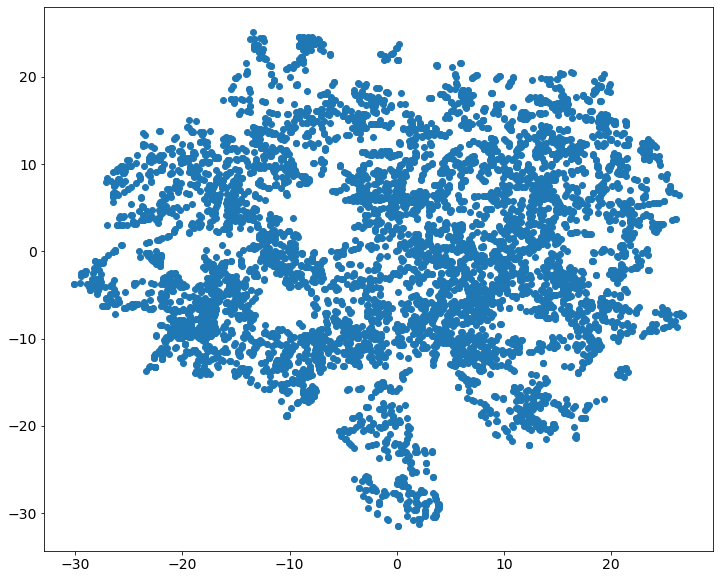

In [28]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])
plt.show()

In [29]:
from sklearn.cluster import KMeans

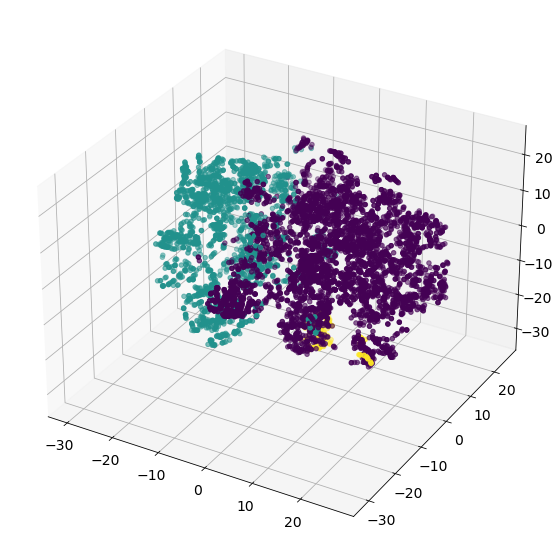

In [30]:
model = KMeans(n_clusters=3, random_state=42, max_iter=200)
model_kmeans = model.fit_predict(X_train_scaled)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = X_train_tsne[:, 0]
y = X_train_tsne[:, 1]
z = X_train_tsne[:, 2]

ax.scatter(x, y, z, c=model_kmeans)

plt.show()

In [31]:
model_kmeans_test = model.predict(X_valid_scaled)
model_kmeans_test_final = model.predict(y_test_scaled)
X_train['klaster'] = model_kmeans
X_valid['klaster'] = model_kmeans_test
test_df['klaster'] = model_kmeans_test_final

In [32]:
#gs.best_params_ {'max_depth': 7, 'min_samples_leaf': 50, 'n_estimators': 100}

### Gradient Boosting Regressor 

In [33]:
X_valid.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,IsDistrictLarge,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear,DistrictYear,DistrictDensity,DistrictPrice,Social,klaster
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3.000000e+03,3000.000000
mean,50.824000,1.902447,59.390465,40.043645,6.810387,7.600667,13.177333,1985.331667,0.120937,24.800333,...,0.396667,1.723667,2.840000,208679.608518,197464.434047,1978.253833,53.379957,3795.724027,-5.573320e-17,0.383000
std,43.588603,0.851775,137.144472,19.808843,5.002093,5.147689,6.466464,18.524778,0.118034,17.481066,...,0.489287,1.285246,1.179914,72387.318706,28270.067001,9.572854,6.324700,987.312503,4.901688e+00,0.543823
min,0.000000,1.000000,4.633498,0.795539,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,89683.296782,159077.198056,1914.000000,36.052307,1727.928366,-1.682017e+00,0.000000
25%,21.000000,1.000000,41.925947,25.859309,3.000000,4.000000,9.000000,1974.000000,0.025609,6.000000,...,0.000000,1.000000,2.000000,162821.511982,179661.919186,1974.000000,47.982081,2913.310685,-1.668774e+00,0.000000
50%,37.000000,2.000000,52.920257,35.703023,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,...,0.000000,2.000000,2.000000,193508.033366,188668.647925,1977.000000,54.756183,3966.567508,-1.272106e+00,0.000000
75%,75.000000,2.000000,66.598344,48.661045,9.000000,11.000000,17.000000,2002.000000,0.200147,35.000000,...,1.000000,3.000000,4.000000,241747.946284,214352.804457,1980.000000,56.895039,4382.501726,-6.709157e-01,1.000000
max,208.000000,13.201945,7480.592129,211.231125,64.395756,37.000000,99.000000,2020.000000,0.521867,74.000000,...,1.000000,4.000000,5.000000,593452.196978,393096.514494,2013.000000,89.845913,8593.064137,2.653017e+01,2.000000


In [34]:
%%time
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=41,  
                                     n_estimators=1200, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.014)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)
print(r2(y_train, y_train_preds))
print(r2(y_valid, y_test_preds))
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

0.8350734206297271
0.7215960078806328
Wall time: 23.6 s


,feature_name,importance
22,MedPriceByDistrict,0.256730
2,Square,0.185140
1,Rooms,0.094966
26,DistrictPrice,0.087606
3,LifeSquare,0.062980
17,DistrictSize,0.038449
28,klaster,0.036768
9,Social_1,0.030718
4,KitchenSquare,0.027643
27,Social,0.021892


In [ ]:
rf = RandomForestRegressor(
    random_state=41, 
    max_depth=20,  
    criterion='mse',
    min_samples_leaf=5,  
    n_jobs=-1,
    n_estimators=1200,
    max_features=17
)
rf.fit(X_train, y_train)
y_train_preds_rf = rf.predict(X_train)
y_test_preds_rf = rf.predict(X_valid)
print(r2(y_train, y_train_preds_rf))
print(r2(y_valid, y_test_preds_rf))

In [ ]:
rf2 = RandomForestRegressor(
    random_state=41, 
    max_depth=40, 
    criterion='mse',
    max_features=20, 
    n_jobs=-1,
    min_samples_leaf=5,
    n_estimators=1800  
)
rf2.fit(X_train, y_train)
y_train_preds_rf2 = rf2.predict(X_train)
y_test_preds_rf2 = rf2.predict(X_valid)
print(r2(y_train, y_train_preds_rf2))
print(r2(y_valid, y_test_preds_rf2))

In [ ]:
rf4 = RandomForestRegressor(
    random_state=41,
    criterion='mse',
    n_jobs=-1
)
rf4.fit(X_train, y_train)
y_train_preds_rf4 = rf4.predict(X_train)
y_test_preds_rf4 = rf4.predict(X_valid)
print(r2(y_train, y_train_preds_rf4))
print(r2(y_valid, y_test_preds_rf4))

In [ ]:
%%time
import xgboost as xgb

xg = xgb.XGBRegressor(colsample_bytree=0.6, 
                              learning_rate=0.013, max_depth=6,
                              min_child_weight=0.2, 
                              n_estimators=1300,
                              reg_lambda=0.6,
                              random_state =41)
xg.fit(X_train, y_train)

y_train_preds_xg = xg.predict(X_train)
y_test_preds_xg = xg.predict(X_valid)
print(r2(y_train, y_train_preds_xg))
print(r2(y_valid, y_test_preds_xg))

DecisionTreeRegressor

In [ ]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=5, 
                                 min_samples_leaf=3,
                                  max_features=20,
                                 random_state=42)
dt_model.fit(X_train, y_train)
y_train_preds_dt = dt_model.predict(X_train)
y_test_preds_dt = dt_model.predict(X_valid)
print(r2(y_train, y_train_preds_dt))
print(r2(y_valid, y_test_preds_dt))

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled_min_max, y_train)

y_train_preds_lr = lr.predict(X_train_scaled_min_max)
y_test_preds_lr = lr.predict(X_valid_scaled_min_max)
print(r2(y_train, y_train_preds_lr))
print(r2(y_valid, y_test_preds_lr))


laso = Lasso(alpha=0.01, random_state=42)

In [ ]:
r = Ridge(alpha=1)
r.fit(X_train, y_train)

y_train_preds_r = r.predict(X_train)
y_test_preds_r = r.predict(X_valid)
print(r2(y_train, y_train_preds_r))
print(r2(y_valid, y_test_preds_r))

In [ ]:
svr = LinearSVR()
svr.fit(X_train, y_train)

y_train_preds_svr = svr.predict(X_train)
y_test_preds_svr = svr.predict(X_valid)
print(r2(y_train, y_train_preds_svr))
print(r2(y_valid, y_test_preds_svr))

In [ ]:
%%time
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor([
                           ('rf', rf),
                          ('rf2', rf2),
                            ('gb_model', gb_model),
                           ('rf4', rf4), 
                        #    ('xg', xg),
                            ('svr', svr),
                            ('lr', lr),
                         #   ('laso', laso),
                            ('rcv', rcv)
                          ],
                          cv=6,
                          n_jobs=-1,
                          final_estimator= gb_model ) #RidgeCV ?
                             
stack.fit(X_train, y_train)
y_train_preds_s = stack.predict(X_train)
y_test_preds_s = stack.predict(X_valid)
print(r2(y_train, y_train_preds_s))
print(r2(y_valid, y_test_preds_s))

In [ ]:
# %%time
# from sklearn.ensemble import StackingRegressor

# stack = StackingRegressor([
#                            ('rf', rf),
#                           ('rf2', rf2),
#                            # ('gb_model', gb_model),
#                            ('rf4', rf4), 
#                         #    ('xg', xg),
#                           #  ('dt', dt_model),
#                          #   ('lr', lr),
#                          #   ('laso', laso),
#                             ('rcv', rcv)
#                           ],
#                           cv=6,
#                           n_jobs=-1,
#                           final_estimator= lr) #RidgeCV ?
                             
# stack.fit(X_train, y_train)
# y_train_preds_s = stack.predict(X_train)
# y_test_preds_s = stack.predict(X_valid_scaled)
# print(r2(y_train, y_train_preds_s))
# print(r2(y_test, y_test_preds_s))

In [ ]:
print("RMSE:\t" + str(round(np.sqrt(mse(y_train, y_train_preds_s)), 3)))
print("RMSE:\t" + str(round(np.sqrt(mse(y_test, y_test_preds_s)), 3)))

In [ ]:
# %%time
# from sklearn.ensemble import StackingRegressor

# stack = StackingRegressor([
#                            ('rf', rf),
#                            ('rf2', rf2),
#                             ('gb_model', gb_model),
#                            ('rf4', rf4), 
#                          #   ('xg', xg),
#                           #  ('dt', dt_model),
#                             ('lr', lr),
#                          #   ('laso', laso),
#                             ('rcv', rcv)
#                           ],
#                           cv=6,
#                           n_jobs=-1,
#                           final_estimator= rcv) #RidgeCV ?
                             
# stack.fit(X_train_scaled, y_train)
# y_train_preds_s = stack.predict(X_train_scaled)
# y_test_preds_s = stack.predict(X_test)
# print(r2(y_train, y_train_preds_s))
# print(r2(y_test, y_test_preds_s))

In [ ]:
# print("RMSE:\t" + str(round(np.sqrt(mse(y_train, y_train_preds_s)), 3)))
# print("RMSE:\t" + str(round(np.sqrt(mse(y_test, y_test_preds_s)), 3)))

In [ ]:
test_df.shape

In [ ]:
submit.shape

In [ ]:
predictions = stack.predict(test_df)
predictions

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('stack_1000.csv', index=False)